In [2]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np 

In [3]:
import numpy as np
import torch
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import scipy.linalg as slin
import scipy.sparse as sp
import networkx as nx
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import glob
import re
import math
from torch.optim.adam import Adam
from utils import *
from statistics import mean
import random

## create data for lag-1 scenario

In [4]:
def simulate_lsem_dynamic(W_all,Z: nx.DiGraph,
                 n: int,n_time:int, treatment_type: str,
                 noise_scale: float = 0.5,
                 baseline: float = 1.0) -> np.ndarray:
    """Simulate samples from LSEM.
        
        Args:
        W_all,A: weigthed DAG for instaneous relation and lagged relation
        n: number of samples in each time-stamp
        lag: degree of AR
        n_time: number of time stamp
        treatment_type: the type of the exposure {Binary, Gaussian}
        noise_scale: noise scale parameter of Gaussian distribution in the lSEM
        baseline: the baseline for the outcome
        
        Returns:
        X: [time,n, d] sample matrix
        """
    #W_array = nx.to_numpy_array(W)
    Z_array = nx.to_numpy_array(Z)
    d = Z_array.shape[0]
    #X_all = np.zeros([n_time+1,n, d])
    
    ## create the initial data
    X = np.zeros([n, d])
    W_0=W_all[0,:,:]
    ordered_vertices = list(nx.topological_sort(nx.from_numpy_matrix(W_0,create_using=nx.DiGraph)))
    assert len(ordered_vertices) == d
    rank_A = ordered_vertices.index(0)
    for j in ordered_vertices:
        if ordered_vertices.index(j) > rank_A:
            parents = list(nx.from_numpy_matrix(W_0,create_using=nx.DiGraph).predecessors(j))
            X[:, j] = X[:, parents].dot(W_0[parents, j]) + np.random.normal(scale=noise_scale, size=n)
        elif ordered_vertices.index(j) < rank_A:
            X[:, j] = np.random.normal(scale=noise_scale, size=n)
        else:
            if treatment_type == 'Binary':
                X[:, j] = 2 * (np.random.binomial(1, 0.5, n) - 0.5)
            elif treatment_type == 'Gaussian':
                X[:, j] = np.random.normal(scale=noise_scale, size=n)
            else:
                raise ValueError('unknown exposure type')
    X[:, d-1] += baseline
    X_all=X
    ## for follow-up time-stamps, X=XW+AZ+E
    for time in range(1,n_time+1):
        X_temp = np.matmul(X,Z_array)
        W_array=W_all[time,:,:] ## different index!
        W=nx.from_numpy_matrix(W_array,create_using=nx.DiGraph)
        for j in ordered_vertices:
            if ordered_vertices.index(j) > rank_A:
                parents = list(W.predecessors(j))
                X_temp[:, j] += X_temp[:, parents].dot(W_array[parents, j]) + np.random.normal(scale=noise_scale, size=n)
            elif ordered_vertices.index(j) < rank_A:
                X_temp[:, j] += np.random.normal(scale=noise_scale, size=n)
            else:
                if treatment_type == 'Binary':
                    X_temp[:, j] += 2 * (np.random.binomial(1, 0.5, n) - 0.5)
                elif treatment_type == 'Gaussian':
                    X_temp[:, j] += np.random.normal(scale=noise_scale, size=n)
                else:
                    raise ValueError('unknown exposure type')
        X_all=np.append(X_all,X_temp,axis=0)
        X=X_temp
    return X_all

In [5]:
W_all=np.zeros([11,5, 5])
import math 
def cos(x):
    return((-15+(5-x)**2)/15)
for i in range(11):
    W_all[i,0,4]=cos(i)

In [6]:
## create Z matrix
Z=np.identity(5)
Z[0,0]=0 # no correlation for treatment
Z_graph=nx.from_numpy_matrix(Z,create_using=nx.DiGraph)

In [7]:
simulate_lsem_dynamic(W_all,Z_graph,30,10, 'Binary',noise_scale=0.1).shape

(330, 5)

## create basis & function demo

In [8]:
np.random.seed(1234567)

t: [ 0.   0.   0.   2.5  5.   7.5 10.  10.  10. ]
c: [ 0.66666667 -0.16666667 -1.         -1.         -0.16666667  0.66666667
  0.          0.          0.        ]
k: 2



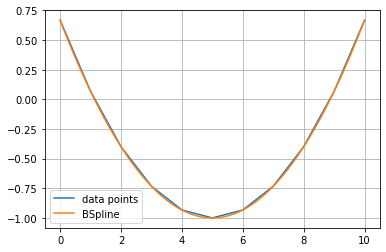

In [9]:
degree =2
x = np.array(range(0, 11))
y = np.array([cos(i) for i in x])
z= [cos(i/10) for i in np.array(range(0, 110))]
m = 3
step = (x[-1] - x[0]) / (m + 1)
knots = np.linspace(step, m * step, m)

t, c, k = interpolate.splrep(x, y, k=degree, s=0, t=knots, per=0)

print('''\
t: {}
c: {}
k: {}
'''.format(t, c, k))
N = 100
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)
spline = interpolate.BSpline(t, c, k, extrapolate=False)

plt.plot(x, y, label='data points')
plt.plot(xx, spline(xx), label='BSpline')
plt.grid()
plt.legend(loc='best')
plt.show()

In [10]:
from scipy.interpolate import BSpline
k = 2
t = t
c1 = [1,0,0,0,0,0]
c2 = [0,1,0,0,0,0]
c3 = [0,0,1,0,0,0]
c4 = [0,0,0,1,0,0]
c5 = [0,0,0,0,1,0]
c6 = [0,0,0,0,0,1]
spl1 = BSpline(t, c1, k)
spl2 = BSpline(t, c2, k)
spl3 = BSpline(t, c3, k)
spl4 = BSpline(t, c4, k)
spl5 = BSpline(t, c5, k)
spl6 = BSpline(t, c6, k)

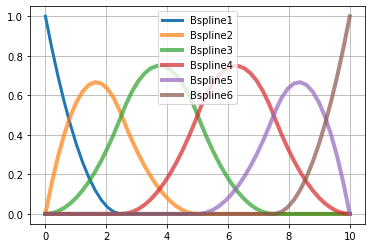

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
xx = np.linspace(0, 10, 50)
ax.plot(xx, spl1(xx), lw=3, label='Bspline1')
ax.plot(xx, spl2(xx), lw=4, alpha=0.7, label='Bspline2')
ax.plot(xx, spl3(xx), lw=4, alpha=0.7, label='Bspline3')
ax.plot(xx, spl4(xx), lw=4, alpha=0.7, label='Bspline4')
ax.plot(xx, spl5(xx), lw=4, alpha=0.7, label='Bspline5')
ax.plot(xx, spl6(xx), lw=4, alpha=0.7, label='Bspline6')
ax.grid(True)
ax.legend(loc='best')
plt.show()

# new method

In [12]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import pickle
import os
import random
import torch.optim as optim
from torch.optim import lr_scheduler
import math
from utils import *

from multiprocessing import Pool
import multiprocessing
n_cores = multiprocessing.cpu_count()
from numpy.random import randn
from random import seed as rseed
from numpy.random import seed as npseed
import time

In [13]:
# ----------- Configurations:
time_stamp=10
n_timestamp=time_stamp
sample__time=30##sample per timepoint
n = time_stamp*sample__time # The number of samples of data.
n_var = 5 # The number of variables in data.
x_dims = 1 # The number of input dimensions: default 1.
z_dims = n_var # The number of latent variable dimensions: default the same as variable size.
epochs = 200 # Number of epochs to train.


In [14]:
n_timestamp

10

In [15]:
sample__time

30

In [16]:
def create_D(X,spline_list):
    D_all=np.zeros((sample__time*time_stamp, n_var*len(spline_list),1))
    for j in range(len(spline_list)):
        D_column=np.zeros((sample__time*time_stamp, n_var,1))#for each spline
        for i in range(0,n_timestamp):
            D_column[(sample__time*i):(sample__time*(i+1)),:,:]=X[(sample__time*i):(sample__time*(i+1)),:]*spline_list[j](i)#X_i *f(i), stack horizontally
        ##horizontally append
        D_all[:,n_var*j:n_var*(j+1),:]=D_column
        #print((n_features*j,n_features*(j+1)))
    return(D_all)

In [17]:
#spline_list=[spl_const]
spline_list=[spl1,spl2,spl3,spl4,spl5,spl6]

In [18]:
def spl_consraint(spline_list,t,p):
    k=len(spline_list)
    output=torch.zeros(((p*k), p))
    identity=torch.zeros((p, p*k))
    for i in range(k):
        output[(i*p):(i*p+p),:]=torch.ones((p,p))*spline_list[i](t).item() #gamma times basis
        identity[:,(i*p):(i*p+p)]=torch.eye(p) #stacked identity matrix
    #final=torch.matmul(identity,output)
    return output, identity

In [19]:
# ----------- Configurations:
n = 30*time_stamp # The number of samples of data.
d = 36 # The number of variables in data after spline.  (p+1*k)
x_dims = 1 # The number of input dimensions: default 1.
z_dims = d # The number of latent variable dimensions: default the same as variable size.
epochs = 200 # Number of epochs to train.
batch_size = 10 # Number of samples per batch. note: should be divisible by sample size, otherwise throw an error.
k_max_iter = int(1e2) # The max iteration number for searching parameters.
original_lr = 3e-3  # Initial learning rate.
encoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
decoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
temp = 0.5 # Temperature for Gumbel softmax.
factor = True # Factor graph model.
encoder_dropout = 0.0 # Dropout rate (1 - keep probability).
decoder_dropout = 0.0 # Dropout rate (1 - keep probability).
tau_B = 0. # Coefficient for L-1 norm of matrix B.
lambda1 = 0. # Coefficient for DAG constraint h1(B).
lambda2 = 0. # Coefficient for identification constraint h2(B).
c_B = 1 # Coefficient for absolute value h1(B).
d_B = 1 # Coefficient for absolute value h2(B).
e_B = 1 # Coefficient for absolute value h3(B)
h1_tol = 1e-8 # The tolerance of error of h1(B) to zero.
h2_tol = 1e-8 # The tolerance of error of h2(B) to zero.
h3_tol = 1e-8 # The tolerance of error of h2(B) to zero.
lr_decay = 200 # After how many epochs to decay LR by a factor of gamma. 
gamma = 1.0 # LR decay factor. 

In [20]:
###edited to remove the first column in the lagged weigttsv
def fun_h2_B_new(B):
    '''compute constraint h2(B) value'''
    d = B.shape[0]
    gamma=B[p:(p+p*k),:p]
    Tau=B[(p+p*k):,:]
    h3_B = sum(sum(abs(B[:p, :])))+sum(abs(gamma[:, 0]))+sum(sum(abs(B[p:, p:])))+ sum(abs(Tau[:, 0]))# uppper 0 and 0 column and every p-1,2p-1 row
    for i in range(k):
        h3_B=h3_B+sum(abs(gamma[((i+1)*p-1), 1:]))
    return h3_B

In [21]:
def fun_h1_B(B):
    '''compute constraint h1(B) value'''
    d = B.shape[0]
    expm_B = matrix_poly(B * B, d)
    h1_B = torch.trace(expm_B) - d
    return h1_B.float()

In [20]:
def train_new(epoch, lambda1, c_B, lambda2, d_B, optimizer, old_lr,p,k):
        
        nll_train = []
        kl_train = []
        mse_train = []
        encoder.train()
        decoder.train()
        scheduler.step()

        # Update optimizer
        optimizer, lr = update_optimizer(optimizer, old_lr, c_B, d_B)

        for batch_idx, (data, relations) in enumerate(train_loader):

            data, relations = Variable(data).double(), Variable(relations).double()
            relations = relations.unsqueeze(2) # Reshape data

            optimizer.zero_grad()

            enc_x, logits, origin_B, adj_A_tilt_encoder, z_gap, z_positive, myA, Wa = encoder(data, rel_rec, rel_send) 
            edges = logits # Logits is of size: [num_sims, z_dims]

            dec_x, output, adj_A_tilt_decoder = decoder(data, edges, d * x_dims, rel_rec, rel_send, origin_B, adj_A_tilt_encoder, Wa)

            if torch.sum(output != output):
                print('nan error\n')

            target = data
            preds = output
            variance = 0.
            
            # Compute constraint functions h1(B) and h2(B)
            #h1_B = fun_h1_B(origin_B[p:,p:]) #acyclity on G
            h1_B =0
            for i in range(n_timestamp):
                #aa=torch.matmul(spl_consraint(spline_list,i,p).type(torch.FloatTensor),origin_B[p:,:p].type(torch.FloatTensor))#acyclity on Gamma
                #print(fun_h1_B(aa))
                output, identity=spl_consraint(spline_list,i,p)
                h1_B=h1_B+fun_h1_B(torch.matmul(identity.type(torch.FloatTensor),(output.type(torch.FloatTensor)*origin_B[p:(p+p*k),:p].type(torch.FloatTensor))))#acyclity on Gamma
            h2_B = fun_h2_B_new(origin_B) ##handle the zero on gamma and top
            # Reconstruction accuracy loss:
            loss_nll = nll_gaussian(preds, target, variance)
            # KL loss:
            loss_kl = kl_gaussian(logits)
            # ELBO loss:
            loss = loss_kl + loss_nll
            # Loss function:
            loss += lambda1 * h1_B + 0.5 * c_B * h1_B * h1_B + lambda2 * h2_B + 0.5 * d_B * h2_B * h2_B + 100. * torch.trace(origin_B * origin_B)

            loss.backward()
            loss = optimizer.step()

            myA.data = stau(myA.data, tau_B * lr)

            if torch.sum(origin_B != origin_B):
                print('nan error\n')

            mse_train.append(F.mse_loss(preds, target).item())
            nll_train.append(loss_nll.item())
            kl_train.append(loss_kl.item())

        return np.mean(np.mean(kl_train) + np.mean(nll_train)), np.mean(nll_train), np.mean(mse_train), origin_B, optimizer, lr


In [27]:
n_var=5
n_times=30 #no. of replicates
time_stamp=10 #no. of timestamp
np.random.seed(1234567) #Random seed
seed_list=np.random.randint(1, 1000000, size=n_times)
average_coef_list_new=np.zeros((n_times,time_stamp,n_var,n_var))
lambda_list=np.zeros((n_times,30,n_var))
t_list=np.zeros((n_times,30,n_var))
for replicate in range(n_times):
  seed=seed_list[replicate]
  X_all=simulate_lsem_dynamic(W_all,Z_graph,30,10, 'Binary',noise_scale=0.1).reshape(330,5,1) #create data
  D=create_D(X_all[30:],spline_list)
  G=create_D(X_all[:-30],spline_list)
  data_all=np.append(X_all[30:],D, axis=1)
  data_all=np.append(data_all,G, axis=1)
  print(np.shape(data_all))
  average_list=np.zeros((time_stamp,n_var, n_var))
  
  ####estimate at each time_stamp####
  timestart_new=time.time()
    # ----------- Configurations:
  # ----------- Configurations:
  n = 30*time_stamp # The number of samples of data.
  d = 65 # The number of variables in data after basis.
  x_dims = 1 # The number of input dimensions: default 1.
  z_dims = d # The number of latent variable dimensions: default the same as variable size.
  epochs = 200 # Number of epochs to train.
  batch_size = 10 # Number of samples per batch. note: should be divisible by sample size, otherwise throw an error.
  k_max_iter = int(1e2) # The max iteration number for searching parameters.
  original_lr = 3e-3  # Initial learning rate.
  encoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
  decoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
  temp = 0.5 # Temperature for Gumbel softmax.
  factor = True # Factor graph model.
  encoder_dropout = 0.0 # Dropout rate (1 - keep probability).
  decoder_dropout = 0.0 # Dropout rate (1 - keep probability).
  tau_B = 0. # Coefficient for L-1 norm of matrix B.
  lambda1 = 0. # Coefficient for DAG constraint h1(B).
  lambda2 = 0. # Coefficient for identification constraint h2(B).
  c_B = 1 # Coefficient for absolute value h1(B).
  d_B = 1 # Coefficient for absolute value h2(B).
  e_B = 1 # Coefficient for absolute value h3(B)
  h1_tol = 1e-8 # The tolerance of error of h1(B) to zero.
  h2_tol = 1e-8 # The tolerance of error of h2(B) to zero.
  h3_tol = 1e-8 # The tolerance of error of h2(B) to zero.
  lr_decay = 200 # After how many epochs to decay LR by a factor of gamma. 
  gamma = 1.0 # LR decay factor.  
    ######################
  p=5
  k=6 #no.of basis
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  feat_train = torch.FloatTensor(data_all)
  feat_valid = torch.FloatTensor(data_all)
  feat_test = torch.FloatTensor(data_all)

  # Reconstruct itself
  train_data = TensorDataset(feat_train, feat_train)
  valid_data = TensorDataset(feat_valid, feat_train)
  test_data = TensorDataset(feat_test, feat_train)

  train_loader = DataLoader(train_data, batch_size = batch_size)
  valid_loader = DataLoader(valid_data, batch_size = batch_size)
  test_loader = DataLoader(test_data, batch_size = batch_size)

  # ----------- Load modules:
  d1=p+p*k+p*k
  off_diag = np.ones([d1, d1]) - np.eye(d1) # Generate off-diagonal interaction graph
  rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype = np.float64)
  rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype = np.float64)
  rel_rec = torch.DoubleTensor(rel_rec)
  rel_send = torch.DoubleTensor(rel_send)
  adj_A = np.zeros((d1, d1)) # Add adjacency matrix

  encoder = MLPEncoder(d1 * x_dims, x_dims, encoder_hidden,
                          int(z_dims), adj_A,
                          batch_size = batch_size,
                          do_prob = encoder_dropout, factor = factor).double()
  decoder = MLPDecoder(d1 * x_dims,
                          z_dims, x_dims, encoder,
                          data_variable_size = d1,
                          batch_size = batch_size,
                          n_hid=decoder_hidden,
                          do_prob=decoder_dropout).double()

  # ----------- Set up optimizer:
  optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = original_lr)
  scheduler = lr_scheduler.StepLR(optimizer, step_size = lr_decay,
                                  gamma = gamma)

  rel_rec = Variable(rel_rec)
  rel_send = Variable(rel_send)

  # ----------- Main:
  best_ELBO_loss = np.inf
  best_NLL_loss = np.inf
  best_MSE_loss = np.inf
  h1_B_new = 1 #torch.tensor(1.)
  h2_B_new = 1
  h1_B_old = np.inf
  h2_B_old = np.inf
  lr = original_lr

  try:
      for step_k in range(k_max_iter):
          while c_B * d_B < 1e+20:
              for epoch in range(epochs):
                  old_lr = lr 
                  ELBO_loss, NLL_loss, MSE_loss, origin_B, optimizer, lr = train_new(epoch, lambda1, c_B, lambda2, d_B, optimizer, old_lr,p=p,k=k)

                  if ELBO_loss < best_ELBO_loss:
                      best_ELBO_loss = ELBO_loss

                  if NLL_loss < best_NLL_loss:
                      best_NLL_loss = NLL_loss

                  if MSE_loss < best_MSE_loss:
                      best_MSE_loss = MSE_loss

              if ELBO_loss > 2 * best_ELBO_loss:
                  break

              # Update parameters
              B_new = origin_B.data.clone()
              #h1_B = fun_h1_B(B_new[p:,p:]) #acyclity on G
              h1_B=0 
              for i in range(n_timestamp):

                  output, identity=spl_consraint(spline_list,i,p)
                  h1_B=h1_B+fun_h1_B(torch.matmul(identity.type(torch.FloatTensor),(output.type(torch.FloatTensor)*B_new[p:(p+p*k),:p].type(torch.FloatTensor))))
                  h2_B = fun_h2_B_new(B_new) ##handle the zero on gamma and top


              if h1_B_new > 0.25 * h1_B_old and h2_B_new > 0.25 * h2_B_old:
                  c_B *= 10
                  d_B *= 10
              elif h1_B_new > 0.25 * h1_B_old and h2_B_new < 0.25 * h2_B_old:
                  c_B *= 10
              elif h1_B_new < 0.25 * h1_B_old and h2_B_new > 0.25 * h2_B_old:
                  d_B *= 10
              else:
                  break

          # Update parameters    
          h1_B_old = h1_B_new
          h2_B_old = h2_B_new
          lambda1 += c_B * h1_B_new
          lambda2 += d_B * h2_B_new

          if h1_B_new <= h1_tol and h2_B_new <= h2_tol:
              break

  except KeyboardInterrupt:
      print('KeyboardInterrupt')

  predB = np.matrix(origin_B.data.clone().numpy())
  print('Best ELBO Loss :', best_ELBO_loss)
  print('Best NLL Loss :', best_NLL_loss)
  print('Best MSE Loss :', best_MSE_loss)
  #calculate_effect(predB)
  pred_gamma=predB[p:(p+p*k),:p]
  lambda_list[replicate,::]=pred_gamma
  np.save("quadra_gamma_constraint",lambda_list)
    
  pred_t=predB[(p+p*k):(p+p*k+p*k),:p]
  t_list[replicate,::]=pred_t
  np.save("quadra_t_constraint",t_list)
  
  print(replicate)


(300, 65, 1)


D:\Anaconda\lib\site-packages\torch\optim\lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Best ELBO Loss : 0.0006572521317412548
Best NLL Loss : 8.543234471009426e-06
Best MSE Loss : 2.628687529541363e-07
0
(300, 65, 1)
Best ELBO Loss : 0.000562884706294232
Best NLL Loss : 1.9649837308829772e-05
Best MSE Loss : 6.046103787332238e-07
1
(300, 65, 1)
Best ELBO Loss : 0.000497214433737149
Best NLL Loss : 1.6332419969508893e-06
Best MSE Loss : 5.025359990618114e-08
2
(300, 65, 1)
Best ELBO Loss : 0.0004462025119103441
Best NLL Loss : 3.02700237705826e-06
Best MSE Loss : 9.313853467871592e-08
3
(300, 65, 1)
Best ELBO Loss : 0.0005240082701485067
Best NLL Loss : 5.1082922809570835e-06
Best MSE Loss : 1.5717822402944908e-07
4
(300, 65, 1)
Best ELBO Loss : 0.0005080231881087511
Best NLL Loss : 1.0247949962102221e-06
Best MSE Loss : 3.15321537295453e-08
5
(300, 65, 1)
Best ELBO Loss : 0.000491894663413181
Best NLL Loss : 3.7245186428640144e-06
Best MSE Loss : 1.1460057362658505e-07
6
(300, 65, 1)
Best ELBO Loss : 0.0008432425149021646
Best NLL Loss : 2.538720904977986e-05
Best MSE Lo

In [23]:
result_new=np.load("quadra_gamma_constraint.npy") #0 axis is the number of replicates
temp=np.load("quadra_10_30_ANOCA_lag.npy")
result_ANOCA=np.load("quadra_10_30_ANOCA_lag_cont.npy")
result_ANOCA[:,:-1,:,:]=temp
result_NOTEARS=np.load("quadra_10_30_NOTEARS_lag.npy")
result_DAGGNN=np.load("quadra_10_30_DAGGNN_lag.npy")
result_dynotears=np.load("dynotears_implementation/result/dynotears_quadratic_w_new.npy")
#result_ANOCA=np.load("quadra_10_30_ANOCA.npy")
#result_NOTEARS=np.load("quadra_10_30_NOTEARS.npy")

In [24]:
p=5
time_stamp=10
n_times=30
n_var=5
#gamma=gamma_est
gamma=np.load("quadra_gamma_constraint.npy")
def matrix_gen_next(t,pred_gamma):
    output,identity=spl_consraint(spline_list,t,p)
    return np.matmul(identity,(np.multiply(output,pred_gamma)))
exten_matrix=np.zeros((n_times,time_stamp+1,n_var,n_var))
for i in range(time_stamp+1):
    estimate=[]
    for replicate in range(n_times):
        exten_matrix[replicate,i,:,:]=matrix_gen_next(i,gamma[replicate,:,:])

In [23]:

FDR_total_new=[]
TPR_total_new=[]
SHD_total_new=[]
for replicate in range(30):
    FDR_list_piece_new=[]
    TPR_list_piece_new=[]
    SHD_list_piece_new=[]
    base_DAG=np.zeros((5, 5))
    for i in range(time_stamp):
      estimate=exten_matrix[replicate,i,:,:]
      estimate[abs(estimate)<0.2] = 0
        
      base_estimate=nx.from_numpy_matrix(estimate,create_using=nx.DiGraph)
      base_DAG[0,4]=cos(i+1)
      base_DAG[abs(base_DAG)<0.2]=0
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
        
      FDR,TPR,SHD=count_accuracy_new(base_graph,base_estimate)
      FDR_list_piece_new.append(FDR)
      TPR_list_piece_new.append(TPR)
      SHD_list_piece_new.append(SHD)
    FDR_total_new.append(mean(FDR_list_piece_new))
    TPR_total_new.append(mean(TPR_list_piece_new))
    SHD_total_new.append(mean(SHD_list_piece_new))
df_new = pd.DataFrame(columns=('FDR', 'TPR',"SHD"))
df_new["FDR"]=FDR_total_new
df_new["TPR"]=TPR_total_new
df_new["SHD"]=SHD_total_new
#df_new["time"]=time_list_new
df_new.mean()

FDR    0.135278
TPR    0.973333
SHD    0.293333
dtype: float64

In [24]:
df_new.std()/math.sqrt(30)

FDR    0.017849
TPR    0.026667
SHD    0.043400
dtype: float64

In [26]:
##dynotears
FDR_total_new=[]
TPR_total_new=[]
SHD_total_new=[]
for replicate in range(30):
    FDR_list_piece_new=[]
    TPR_list_piece_new=[]
    SHD_list_piece_new=[]
    base_DAG=np.zeros((5, 5))
    for i in range(time_stamp):
      estimate=result_dynotears[replicate,i,:,:]
      estimate[abs(estimate)<0.2] = 0
        
      base_estimate=nx.from_numpy_matrix(estimate,create_using=nx.DiGraph)
      base_DAG[0,4]=cos(i+1)
      base_DAG[abs(base_DAG)<0.2]=0
      base_graph=nx.from_numpy_matrix(base_DAG.T,create_using=nx.DiGraph)
        
      FDR,TPR,SHD=count_accuracy_new(base_graph,base_estimate)
      FDR_list_piece_new.append(FDR)
      TPR_list_piece_new.append(TPR)
      SHD_list_piece_new.append(SHD)
    FDR_total_new.append(mean(FDR_list_piece_new))
    TPR_total_new.append(mean(TPR_list_piece_new))
    SHD_total_new.append(mean(SHD_list_piece_new))
df_new = pd.DataFrame(columns=('FDR', 'TPR',"SHD"))
df_new["FDR"]=FDR_total_new
df_new["TPR"]=TPR_total_new
df_new["SHD"]=SHD_total_new
#df_new["time"]=time_list_new
df_new.mean()

FDR    0.313333
TPR    0.703333
SHD    0.316667
dtype: float64

In [27]:
df_new.std()/math.sqrt(30)

FDR    0.009264
TPR    0.005839
SHD    0.009689
dtype: float64

In [28]:
#ANOCA
base_DAG=np.zeros((5, 5))
FDR_total=[]
TPR_total=[]
SHD_total=[]
for replicate in range(n_times):
    FDR_list_piece=[]
    TPR_list_piece=[]
    SHD_list_piece=[]
    for i in range(time_stamp):
      base_DAG[0,4]=cos(i)
      base_DAG[abs(base_DAG)<0.2]=0
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      a=result_ANOCA[replicate,i+1,:,:]
      a[abs(a)<0.2] = 0
      base_estimate=nx.from_numpy_matrix(a,create_using=nx.DiGraph)

      FDR,TPR,SHD=count_accuracy_new(base_graph,base_estimate)
      FDR_list_piece.append(FDR)
      TPR_list_piece.append(TPR)
      SHD_list_piece.append(SHD)
    FDR_total.append(mean(FDR_list_piece))
    TPR_total.append(mean(TPR_list_piece))
    SHD_total.append(mean(SHD_list_piece))
df = pd.DataFrame(columns=('FDR', 'TPR',"SHD"))
df["FDR"]=FDR_total
df["TPR"]=TPR_total
df["SHD"]=SHD_total
#df_new["time"]=time_list_new
df.mean()

FDR    0.774722
TPR    0.833333
SHD    2.613333
dtype: float64

In [29]:
df.std()/math.sqrt(30)

FDR    0.012630
TPR    0.015413
SHD    0.095139
dtype: float64

In [25]:
#DAGGNN
base_DAG=np.zeros((5, 5))
FDR_total=[]
TPR_total=[]
SHD_total=[]
for replicate in range(n_times):
    FDR_list_piece=[]
    TPR_list_piece=[]
    SHD_list_piece=[]
    for i in range(time_stamp):
      base_DAG[0,4]=cos(i)
      base_DAG[abs(base_DAG)<0.2]=0
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      a=result_DAGGNN[replicate,i,:,:]
      a[abs(a)<0.2] = 0
      base_estimate=nx.from_numpy_matrix(a,create_using=nx.DiGraph)

      FDR,TPR,SHD=count_accuracy_new(base_graph,base_estimate)
      FDR_list_piece.append(FDR)
      TPR_list_piece.append(TPR)
      SHD_list_piece.append(SHD)
    FDR_total.append(mean(FDR_list_piece))
    TPR_total.append(mean(TPR_list_piece))
    SHD_total.append(mean(SHD_list_piece))
df = pd.DataFrame(columns=('FDR', 'TPR',"SHD"))
df["FDR"]=FDR_total
df["TPR"]=TPR_total
df["SHD"]=SHD_total
#df_new["time"]=time_list_new
df.mean()

FDR    0.804730
TPR    0.760000
SHD    3.096667
dtype: float64

In [26]:
df.std()/math.sqrt(30)

FDR    0.010987
TPR    0.016330
SHD    0.127800
dtype: float64

In [77]:
#NOTEARS
base_DAG=np.zeros((5, 5))
FDR_total=[]
TPR_total=[]
SHD_total=[]
for replicate in range(n_times):
    FDR_list_piece=[]
    TPR_list_piece=[]
    SHD_list_piece=[]
    for i in range(time_stamp):
      base_DAG[0,4]=cos(i)
      base_DAG[abs(base_DAG)<0.2]=0
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      a=result_NOTEARS[replicate,i+1,:,:]
      a[abs(a)<0.2] = 0
      base_estimate=nx.from_numpy_matrix(a,create_using=nx.DiGraph)

      FDR,TPR,SHD=count_accuracy_new(base_graph,base_estimate)
      FDR_list_piece.append(FDR)
      TPR_list_piece.append(TPR)
      SHD_list_piece.append(SHD)
    FDR_total.append(mean(FDR_list_piece))
    TPR_total.append(mean(TPR_list_piece))
    SHD_total.append(mean(SHD_list_piece))
df = pd.DataFrame(columns=('FDR', 'TPR',"SHD"))
df["FDR"]=FDR_total
df["TPR"]=TPR_total
df["SHD"]=SHD_total
#df_new["time"]=time_list_new
df.mean()

FDR    0.386389
TPR    0.700000
SHD    0.796667
dtype: float64

In [78]:
df.std()/math.sqrt(30)

FDR    0.026911
TPR    0.019769
SHD    0.059593
dtype: float64

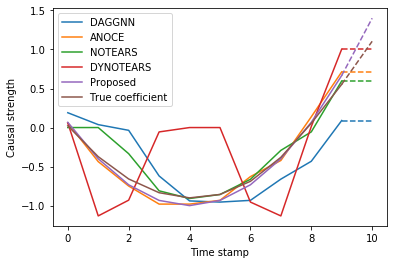

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
from cycler import cycler
import numpy as np
fig, ax=plt.subplots(1)
d=pd.DataFrame({#'e':EDISON_list.mean(axis=0)[:,0,4],
                'f': np.append(result_DAGGNN[:,:,0,4].mean(axis=0),result_DAGGNN[:,-1,0,4].mean(axis=0)),
                'e': np.append(result_ANOCA[:,1:,0,4].mean(axis=0),result_ANOCA[:,-1,0,4].mean(axis=0)),
                'd':np.append(result_NOTEARS[:,1:,0,4].mean(axis=0),mean(result_NOTEARS[:,-1,0,4])),
                'a':np.append(result_dynotears.mean(axis=0)[:,4,0],result_dynotears.mean(axis=0)[-1,4,0]),
                'c':[cos(i+1) for i in range(time_stamp+1)],
                'b':exten_matrix.mean(axis=0)[:,0,4],
                
               })
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.set_prop_cycle(cycler('color', colors[:6]))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.plot(d[:-1],'-',d[-2:],'--')
plt.legend(["DAGGNN","ANOCE","NOTEARS","DYNOTEARS","Proposed", "True coefficient",])
  
# function to show the plot
plt.xlabel("Time stamp")
plt.ylabel("Causal strength")
plt.savefig("quadratic_lag.pdf")

In [27]:
MSE_list_proposed=[]
MSE_list_dynotears=[]
MSE_list_ANOCA=[]
MSE_list_NOTEARS=[]
MSE_list_DAGGNN=[]
for j in range(30):
    MSE_list_dynotears.append(mean((result_dynotears[j,:,4,0]-[cos(i+1)for i in range(10)])**2))
    MSE_list_proposed.append(mean((exten_matrix[j,:-1,0,4]-[cos(i+1)for i in range(10)])**2))
    MSE_list_ANOCA.append(mean((result_ANOCA[j,1:,0,4]-[cos(i+1)for i in range(10)])**2))
    MSE_list_DAGGNN.append(mean((result_DAGGNN[j,:,0,4]-[cos(i+1)for i in range(10)])**2))
    MSE_list_NOTEARS.append(mean((result_NOTEARS[j,1:,0,4]-[cos(i+1)for i in range(10)])**2))

In [28]:
import statistics
print("dynotears",round(mean(MSE_list_dynotears),2), round(statistics.pstdev(MSE_list_dynotears)/math.sqrt(30),3))
print("proposed",round(mean(MSE_list_proposed),2), round(statistics.pstdev(MSE_list_proposed)/math.sqrt(30),3))
print("ANOCA",round(mean(MSE_list_ANOCA),2), round(statistics.pstdev(MSE_list_ANOCA)/math.sqrt(30),3))
print("NOTEARS",round(mean(MSE_list_NOTEARS),2), round(statistics.pstdev(MSE_list_NOTEARS)/math.sqrt(30),3))
print("DAGGNN",round(mean(MSE_list_DAGGNN),2), round(statistics.pstdev(MSE_list_DAGGNN)/math.sqrt(30),3))

dynotears 0.4 0.005
proposed 0.02 0.011
ANOCA 0.09 0.009
NOTEARS 0.13 0.01
DAGGNN 0.24 0.014


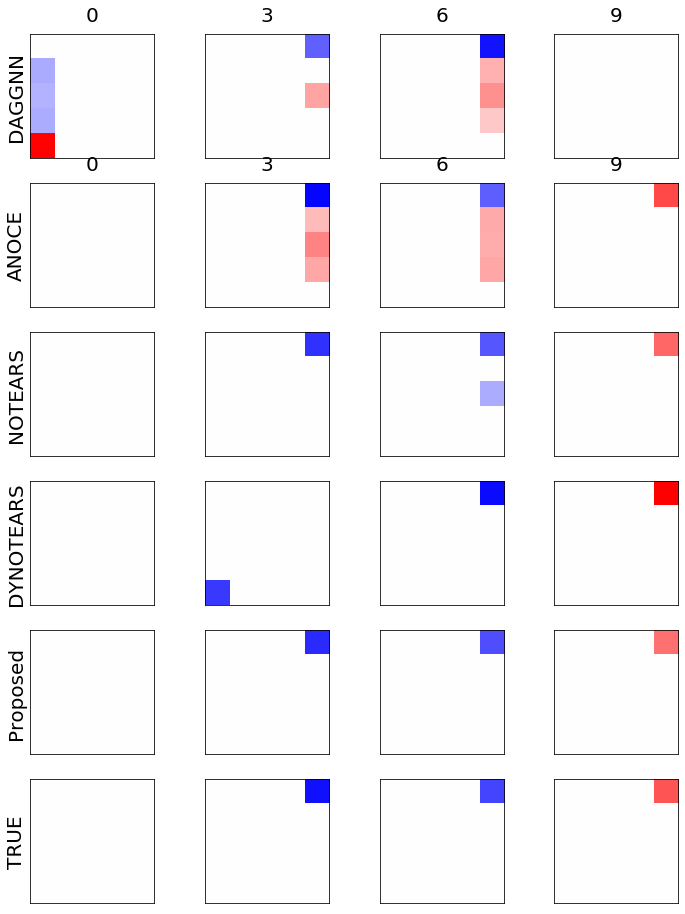

In [29]:
select_time=[0,3,6,9]
methods=["DAGGNN","ANOCE","NOTEARS","DYNOTEARS","Proposed","TRUE"]
figure, axs = plt.subplots(nrows=len(methods), ncols=4, figsize=(12, 16))
for i in range(len(select_time)):
    actual_time=select_time[i]
    #DAGGNN
    DAGGNN_graph=result_DAGGNN[:,actual_time,:,:].mean(axis=0)
    DAGGNN_graph[abs(DAGGNN_graph)<0.2]=0
    axs[0, i].matshow(DAGGNN_graph, cmap = 'bwr', vmin = -1, vmax = 1)
    axs[0, i].set_title(str((select_time[i])),fontdict={'fontsize': 20})
    ##ANOCA
    ANOCA_graph=result_ANOCA[:,actual_time+1,:,:].mean(axis=0)
    ANOCA_graph[abs(ANOCA_graph)<0.2]=0
    axs[1, i].matshow(ANOCA_graph, cmap = 'bwr', vmin = -1, vmax = 1)
    axs[1, i].set_title(str((select_time[i])),fontdict={'fontsize': 20})
    ##NOTEARS plot
    NOTEARS_graph=result_NOTEARS[:,actual_time+1,:,:].mean(axis=0)
    NOTEARS_graph[abs(NOTEARS_graph)<0.2]=0
    axs[2, i].matshow(NOTEARS_graph, cmap = 'bwr', vmin = -1, vmax = 1)
    ##DYNOTEARS plot
    DYNOTEARS_graph=result_dynotears[:,actual_time,:,:].mean(axis=0).T
    DYNOTEARS_graph[abs(DYNOTEARS_graph)<0.2]=0
    axs[3, i].matshow(DYNOTEARS_graph, cmap = 'bwr', vmin = -1, vmax = 1)
    ##proposed plot
    proposed_graph=exten_matrix[:,actual_time,:,:].mean(axis=0)
    proposed_graph[abs(proposed_graph)<0.2]=0
    axs[4, i].matshow(proposed_graph, cmap = 'bwr', vmin = -1, vmax = 1)
    ##True plot
    true=np.zeros([5, 5])
    true[0,4]=cos(actual_time+1)
    true[abs(true)<0.2]=0
    axs[5, i].matshow(true, cmap = 'bwr', vmin = -1, vmax = 1)
for j in range(len(methods)):
    axs[j, 0].set(ylabel=methods[j])
    axs[j, 0].yaxis.label.set_size(20)
for i in range(len(methods)):
    for j in range(4):
        axs[i][j].get_xaxis().set_ticks([])
        axs[i][j].get_yaxis().set_ticks([])
plt.savefig("quadra_lag_graph.pdf")


## W_T

In [30]:
result_new=np.load("quadra_t_constraint.npy")
gamma_list=result_new


In [31]:
p=5
time_stamp=10
n_times=30
n_var=5
gamma=gamma_list
def matrix_gen_next(t,pred_gamma):
    output,identity=spl_consraint(spline_list,t,p)
    return np.matmul(identity,(np.multiply(output,pred_gamma)))
exten_matrix=np.zeros((n_times,time_stamp+1,n_var,n_var))
for i in range(time_stamp+1):
    estimate=[]
    for replicate in range(n_times):
        exten_matrix[replicate,i,:,:]=matrix_gen_next(i,gamma[replicate,:,:])

In [19]:
##PROPOSED
FDR_total_new=[]
TPR_total_new=[]
SHD_total_new=[]
for replicate in range(30):
    FDR_list_piece_new=[]
    TPR_list_piece_new=[]
    SHD_list_piece_new=[]
    base_DAG=np.zeros((5, 5))
    ## create Z matrix
    Z=np.identity(5)
    Z[0,0]=0 # no correlation for treatment
    Z_graph=nx.from_numpy_matrix(Z,create_using=nx.DiGraph)
    for i in range(time_stamp):
      estimate=exten_matrix[replicate,i,:,:]
      estimate[abs(estimate)<0.2] = 0       
      base_estimate=nx.from_numpy_matrix(estimate,create_using=nx.DiGraph)
      base_graph=Z_graph
        
      FDR,TPR,SHD=count_accuracy_new(base_graph,base_estimate)
      FDR_list_piece_new.append(FDR)
      TPR_list_piece_new.append(TPR)
      SHD_list_piece_new.append(SHD)
    FDR_total_new.append(mean(FDR_list_piece_new))
    TPR_total_new.append(mean(TPR_list_piece_new))
    SHD_total_new.append(mean(SHD_list_piece_new))
df_new = pd.DataFrame(columns=('FDR', 'TPR',"SHD"))
df_new["FDR"]=FDR_total_new
df_new["TPR"]=TPR_total_new
df_new["SHD"]=SHD_total_new
#df_new["time"]=time_list_new
df_new.mean()

FDR    0.257877
TPR    0.975000
SHD    1.930000
dtype: float64

In [20]:
df_new.std()/math.sqrt(30)

FDR    0.008599
TPR    0.004642
SHD    0.078220
dtype: float64

In [29]:
result_dynotears=np.load("dynotears_implementation/result/dynotears_quadratic_a.npy")

In [30]:
##dynotears
FDR_total_new=[]
TPR_total_new=[]
SHD_total_new=[]
for replicate in range(30):
    FDR_list_piece_new=[]
    TPR_list_piece_new=[]
    SHD_list_piece_new=[]
    base_DAG=np.zeros((5, 5))
    ## create Z matrix
    Z=np.identity(5)
    Z[0,0]=0 # no correlation for treatment
    Z_graph=nx.from_numpy_matrix(Z,create_using=nx.DiGraph)
    for i in range(time_stamp):
      estimate=result_dynotears[replicate,i,:,:]
      estimate[abs(estimate)<0.2] = 0
        
      base_estimate=nx.from_numpy_matrix(estimate,create_using=nx.DiGraph)
      base_graph=Z_graph
        
      FDR,TPR,SHD=count_accuracy_new(base_graph,base_estimate)
      FDR_list_piece_new.append(FDR)
      TPR_list_piece_new.append(TPR)
      SHD_list_piece_new.append(SHD)
    FDR_total_new.append(mean(FDR_list_piece_new))
    TPR_total_new.append(mean(TPR_list_piece_new))
    SHD_total_new.append(mean(SHD_list_piece_new))
df_new = pd.DataFrame(columns=('FDR', 'TPR',"SHD"))
df_new["FDR"]=FDR_total_new
df_new["TPR"]=TPR_total_new
df_new["SHD"]=SHD_total_new
#df_new["time"]=time_list_new
df_new.mean()

FDR    0.401389
TPR    0.273333
SHD    3.750000
dtype: float64

In [31]:
df_new.std()/math.sqrt(30)

FDR    0.005055
TPR    0.005484
SHD    0.022361
dtype: float64

In [ ]:
MSE_list_proposed=[]
MSE_list_dynotears=[]
MSE_list_ANOCA=[]
MSE_list_NOTEARS=[]
for j in range(30):
    MSE_list_dynotears.append(mean((result_dynotears[j,:,4,0]-[cos(i+1)for i in range(10)])**2))
    MSE_list_proposed.append(mean((exten_matrix[j,:-1,0,4]-[cos(i+1)for i in range(10)])**2))
    MSE_list_ANOCA.append(mean((result_ANOCA[j,1:,0,4]-[cos(i+1)for i in range(10)])**2))
    MSE_list_NOTEARS.append(mean((result_NOTEARS[j,1:,0,4]-[cos(i+1)for i in range(10)])**2))

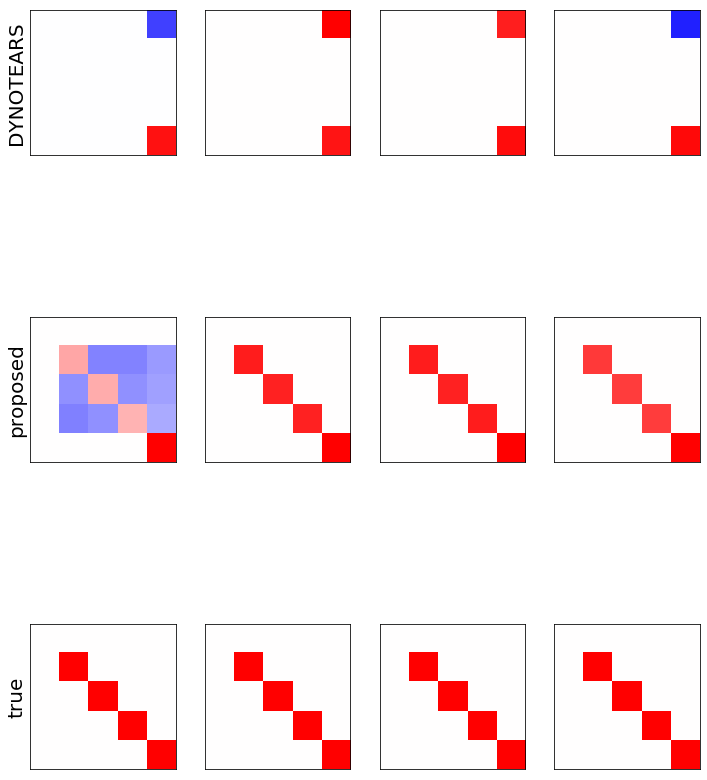

In [32]:
select_time=[0,3,6,9]
methods=["DYNOTEARS","proposed","true"]
figure, axs = plt.subplots(nrows=len(methods), ncols=4, figsize=(12, 16))
for i in range(len(select_time)):
    actual_time=select_time[i]
    ##DYNOTEARS plot
    DYNOTEARS_graph=result_dynotears[:,actual_time,:,:].mean(axis=0).T
    DYNOTEARS_graph[abs(DYNOTEARS_graph)<0.2]=0
    axs[0, i].matshow(DYNOTEARS_graph, cmap = 'bwr', vmin = -1, vmax = 1)
    ##proposed plot
    proposed_graph=exten_matrix[:,actual_time,:,:].mean(axis=0)
    proposed_graph[abs(proposed_graph)<0.2]=0
    axs[1, i].matshow(proposed_graph, cmap = 'bwr', vmin = -1, vmax = 1)
    ##True plot
    true=np.identity(5)
    true[0,0]=0
    true[abs(true)<0.2]=0
    axs[2, i].matshow(true, cmap = 'bwr', vmin = -1, vmax = 1)
for j in range(len(methods)):
    axs[j, 0].set(ylabel=methods[j])
    axs[j, 0].yaxis.label.set_size(20)
for i in range(3):
    for j in range(4):
        axs[i][j].get_xaxis().set_ticks([])
        axs[i][j].get_yaxis().set_ticks([])
plt.savefig("quadra_lag_graph_Wt.pdf")